<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA

In [2]:
%pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=347f75db67c39007aba6ee5693ec22deda5618deeeb5242cdde648698ad945aa
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=230dc7d9d0f2135b61018a066e5e72a88d485a09c76c36210748ee752a263780
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
# train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [4]:
train.head()

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1
2,"Before Persephone was released to Hermes , who...",before persephone be release to hermes who hav...,6.594628,5.231351,2.78,11.17,2.537222,1.43,4.86,42.0,1
3,Cogeneration plants are commonly found in dist...,cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.429643,1.52,4.93,32.0,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",geneva lrb rrb be the secondmostpopulous city ...,9.847729,5.455000,3.69,12.62,2.399333,1.43,4.79,28.0,1


In [56]:
sample_df = train.groupby('label').apply(lambda x: x.sample(10000, random_state=99))
sample_df.index = sample_df.index.get_level_values(1)
sample_df.head()

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
256892,"He studied art in Berlin , Essen , and Munich ...",he study art in berlin essen and munich before...,8.097500,5.320769,2.89,12.22,2.663077,1.33,4.92,20.0,0
302461,There are paw prints of cave bears . There are...,there be paw print of cave bear there be also ...,1.780475,5.568750,3.58,10.71,2.933333,1.43,4.96,16.0,0
336641,The album also won the band a 2003 Swedish Gra...,the album also win the band a 2003 swedish gra...,6.714850,5.029231,2.89,7.74,2.855833,1.43,4.91,16.0,0
336467,"Communist Hungary , 1946-1989",communist hungary 19461989,15.938800,13.220000,13.22,13.22,3.500000,3.50,3.50,3.0,0
413140,Both his teaching and his textbook were instru...,both he teach and he textbook be instrumental ...,8.356977,6.015652,2.89,11.84,2.730909,1.43,4.93,27.0,0


In [57]:
sample_df.label.value_counts()

0    10000
1    10000
Name: label, dtype: int64

In [7]:
nlp = spacy.load("en_core_web_sm")

In [58]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [18]:
# My gridsearch-ish attempt at running k-means.  This routine will
# create a dictionary containing the cluster numbers, scores and 
# saves the best model found (as identified by score)

def find_best_kmeans(X,n_clus_lst):
 
  m = {'cluster':[],
       'score':[],
       'best_model':None}

  for idx, n in enumerate(n_clus_lst):
    km = KMeans(n_clusters=n,max_iter=500,
                random_state=99)
    km.fit(X)
    score = silhouette_score(X,km.labels_,
                    random_state=99)
    m['cluster'].append(n)
    if m['best_model'] == None:
      m['best_model'] = km
    elif score > np.max(m['score']):
      m['best_model'] = km    
    m['score'].append(score)
    
  return m


def plot_clusters(feature_one, feature_two, labels,title):
  # routine to plot out the clusters
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("PCA Feature 1")
  plt.ylabel("PCA Feature 2")
  sns.scatterplot(x=feature_one,
                  y=feature_two,
                  hue=labels,
                  alpha=.3,
                  );

In [ ]:
# old code
# X_std = StandardScaler().fit_transform(X)
# X_pca = PCA(n_components=5).fit_transform(X_std)

In [22]:

# Create a preprocessing pipeline for Clustering
preprocessor = Pipeline([('scaler', StandardScaler()),
                        #  
                        ])


In [23]:
import seaborn as sns

Best Score: 0.5167478322982788


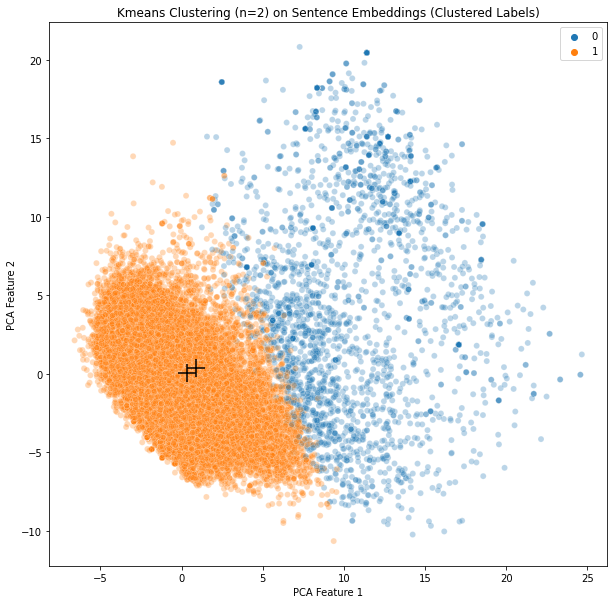

In [42]:
X_std = preprocessor.fit_transform(X)
X_pca = PCA(n_components=5).fit_transform(X_std)

# find best results from kmeans using standardized data
results = find_best_kmeans(X, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)


# plot out the data against Reduced Dimensions
km = results['best_model']
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              km.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


In [43]:
# k-means found cluster separation however, the Silo score is around .5, 
# which doesn't imply great clustering separation.
# The plus signs are the respective cluster centers. Looking at what 
# sentences are clustered close by the centers for additional information

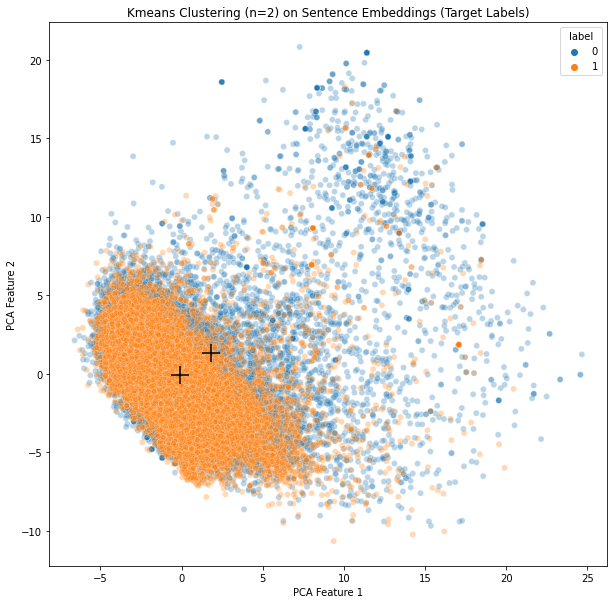

In [26]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [44]:
#code modified from https://stackoverflow.com/questions/69164379/how-to-find-the-index-of-the-point-closest-to-k-means-cluster-centers-using-skle
from scipy.spatial.distance import euclidean

def top_sentences_by_cluster(X,km,df):
  closest_pt_idx = []
  for iclust in range(km.n_clusters):
      # get all points assigned to each cluster:
      cluster_pts = X[km.labels_ == iclust]
      # get all indices of points assigned to this cluster:
      cluster_pts_indices = np.where(km.labels_ == iclust)[0]

      cluster_cen = km.cluster_centers_[iclust]
      top = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[:10]
      bottom = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[-10:]

      print(" ")
      print(f" Cluster {iclust + 1}")
      print("--------------")
      # Print out the results for each cluster:
      print(f" ")
      print(f'top 10 closest sentences to cluster {iclust}\'s center:')
      for sent_vec in top:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])
      print(" ")
      print(f'farthest sentences to cluster {iclust}\'s center:')
      for sent_vec in bottom[::-1]:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])


In [45]:
top_sentences_by_cluster(X_std,km,sample_df)

 
 Cluster 1
--------------
 
top 10 closest sentences to cluster 0's center:
Surprise -LRB- Paul Simon album -RRB- , a 2006 album by Paul Simon
Nakajima scored two points at Monaco .
Justus von Liebig -LRB- 1803-1873 -RRB- , Chemist , Professor .
Eddie Cantor -LRB- 1892-1964 -RRB- , American comedian , singer , actor , songwriter
Justus von Liebig -LRB- 1803 -- 1873 -RRB- , chemist , professor .
He lives in Chiswick , London , United Kingdom
Won World Series vs Cleveland Indians , 4-2 .
Aisha Campbell - The second Yellow Ranger .
Avon , Ohio , a city
Charles Macintosh -LRB- 1766 -- 1843 -RRB- , Scottish inventor
 
farthest sentences to cluster 0's center:
Also
2007 .
2007 .
254-271 .
s
138-141 .
2005
Chalkhills :
-LRB-/O1994/O-RRB-
18.959
 
 Cluster 2
--------------
 
top 10 closest sentences to cluster 1's center:
Lemony Snicket is the legal pen name of American novelist Daniel Handler -LRB- born February 28 , 1970 -RRB- . Snicket is the author of several children 's books , serving 

In [31]:
# It appears the K-Means algorithm found clusters based on 
# sentence length for the sentence embeddings.  
# Cluster 2 appears to only have 1 word in the original text

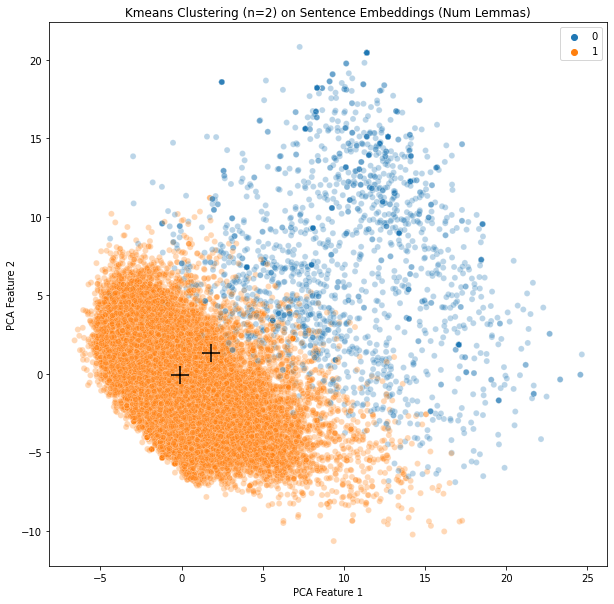

In [32]:
# Plotting using num_lemmas for color (1 is 3 or more lemmas, otherwise 0)

gt_one_lemma = [1 if x >= 3 else 0 for x in sample_df.num_lemmas]

plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=gt_one_lemma,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [33]:
# quick calculation to get how many numbers are in each text for confirmation
sample_df['numbers'] = [len([y for y in x.split(' ') if y.isdigit()]) for x in sample_df.lemmatized_text]


def proportion_nums(x):
  if x['numbers'] > 0:
      prop = x['numbers'] / x['num_lemmas']
      if prop < .25:
        return 0
      elif prop > .25 and prop < .5:
        return 1
      elif prop > .5 and prop < .75:
        return 2
      else:
        return 3
  else:
    return 0



sample_df['numbers'] = sample_df.apply(lambda x: proportion_nums(x), axis=1)

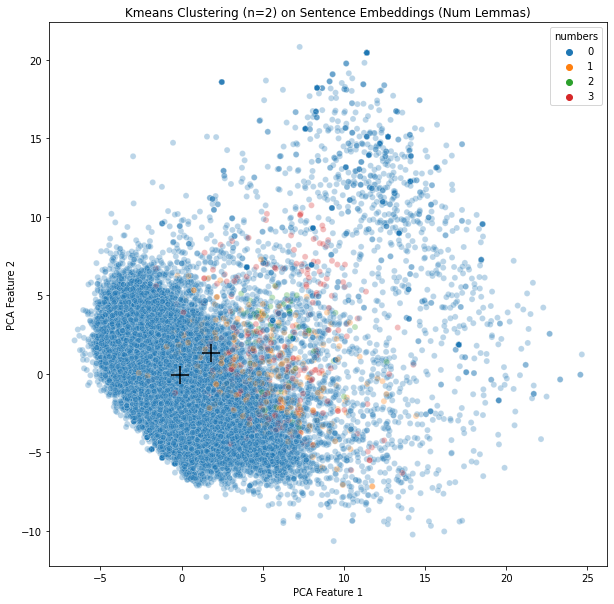

In [34]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.numbers,
                alpha=.3,
                legend='full',palette=sns.color_palette()[:4])

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [35]:
sample_df['emb_member'] = km.labels_

In [ ]:
sample_df = sample_df.reset_index(drop=True)


In [37]:
(sample_df.groupby(['label','emb_member'])['lemmatized_text'].count())

label  emb_member
0      0              1928
       1             23072
1      0               352
       1             24648
Name: lemmatized_text, dtype: int64

In [38]:
# There seems to be a disagreement with the first
# found cluster's membership and the label.  

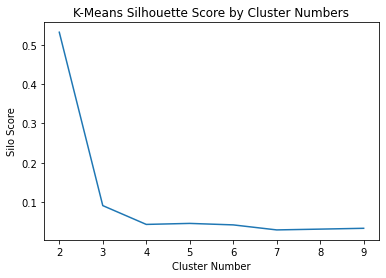

In [39]:
plt.title("K-Means Silhouette Score by Cluster Numbers")
sns.lineplot(x=results['cluster'],
             y=results['score'])
plt.xlabel('Cluster Number')
plt.ylabel('Silo Score');

In [40]:
def find_best_clusters_kpca_value(kernel):
  if kernel == "":
    kernel = 'linear'

  metrics = {'gamma': [],
            'clusters': [],
            'score': []
            }

  for g in [.001,.01,1, 10,100]:
    X_kpca = KernelPCA(n_components=5,
                       kernel=kernel,
                       gamma=g).fit_transform(X_std)
    results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
    for idx, score in enumerate(results['score']):
      metrics['gamma'].append(g)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return pd.DataFrame(metrics),metrics

In [41]:
metrics_df,metrics = find_best_clusters_kpca_value('linear')
metrics_df.sort_values('score', ascending=False)[:5]

KeyboardInterrupt: ignored

In [ ]:
metrics_df,metrics = find_best_clusters_kpca_value('rbf')
metrics_df.sort_values('score', ascending=False)[:5]

,gamma,clusters,score
36,100.0,6,0.999940
28,10.0,6,0.999940
20,1.0,6,0.999933
35,100.0,5,0.997894
27,10.0,5,0.997894


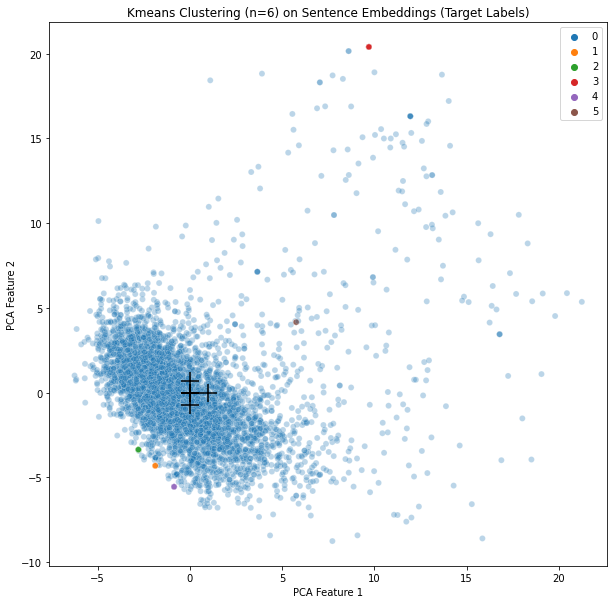

In [ ]:
X_kpca = KernelPCA(n_components=5, gamma=1, kernel='rbf').fit_transform(X_std)
results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=km.labels_,
                alpha=.3,
                palette=sns.color_palette()[:km.n_clusters],
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
# The K-Means Clustering with Kernel PCA Rbf function membership counts
np.bincount(km.labels_)

array([4960,    8,    7,   11,    8,    6])

In [ ]:
#!pip install ipympl

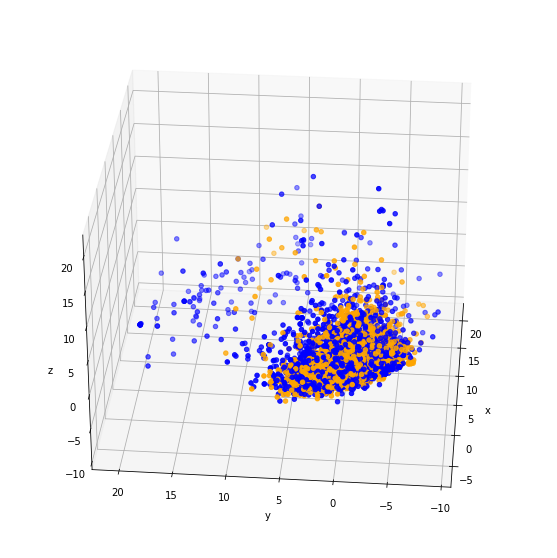

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# from mpl_toolkits import mplot3d
# %matplotlib widget

cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
plt.figure(figsize=(10,10))
axes = plt.axes(projection='3d')
axes.scatter3D(X_pca[:,0], X_pca[:,1],X_pca[:,2,],
               c=sample_df.label, cmap=cmap)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.view_init(30, 185)
plt.show()



In [ ]:
import plotly.express as px


fig = px.scatter_3d(sample_df, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
              color='label')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show()

# K-Means Clustering on Tfidf Vectorized Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer( min_df=20,
                      ngram_range=(1,3)
                      )
X_vec = vec.fit_transform(sample_df['lemmatized_text'])
X_vec_PCA = PCA(n_components=5).fit_transform(X_vec.toarray())

In [ ]:
n_clust_lst = [x for x in range(2,11)]
tf_results = find_best_kmeans(X_vec_PCA,n_clust_lst)

In [ ]:
tf_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.3502954557217614,
  0.39016667464732474,
  0.29140696914484326,
  0.3193035420582798,
  0.259653259061888,
  0.2577439650141051,
  0.26945999374966784,
  0.26970390452109744,
  0.2717220420851382],
 'best_model': KMeans(n_clusters=2, random_state=99)}

Best Score (tfidf): 0.6093838810920715


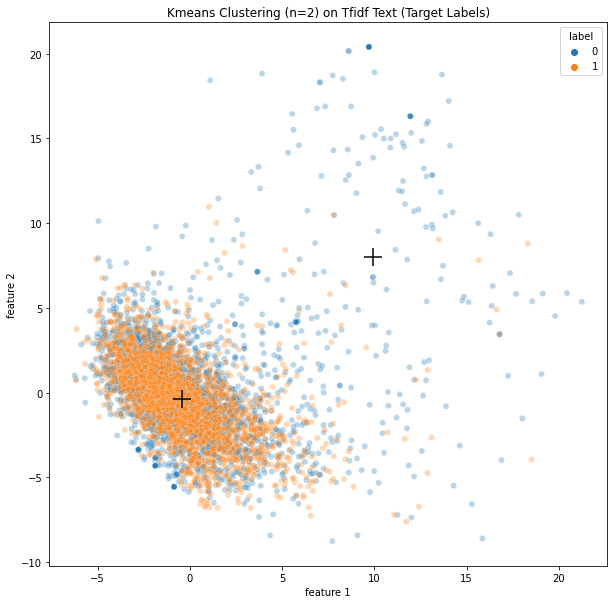

In [ ]:
print(f"Best Score (tfidf): {np.max(results['score'])}")
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Tfidf Text (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
top_sentences_by_cluster(X_vec_PCA,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
Oxygen was independently discovered by Carl Wilhelm Scheele , in Uppsala , in 1773 or earlier , and Joseph Priestley in Wiltshire , in 1774 , but Priestley is often given priority because his publication came out in print first .
They obtained independence in 1960 .
After receiving a first prize in organ performance and improvisation in 1941 , Jeanne Demessieux studied five more years with Dupré in Meudon , before she played her début recital at Salle Pleyel in Paris in 1946 .
This happens at about 1 bit in 1015 in enterprise-class disk drives , and 1 bit in 1014 in ordinary disk drives .
This season was also the first to have a tiebreaker challenge : in , the person that had most votes against them in earlier Tribal Councils was voted out in such a situation , but in Samburus first tribal council , Carl Bilancione and Lindsey Richter each had four votes .
In The Brothers Karamazov , the character Dimitri Karamazov asks his atheist frie

# Numeric Features

In [ ]:
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)


In [ ]:
metrics = find_best_kmeans(X_num_std,[2,3,4,5,6,7,8])

In [ ]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8],
 'score': [0.578215750326415,
  0.5827496800305163,
  0.1915945984651341,
  0.22061948770636472,
  0.2286004387003079,
  0.20774957793808052,
  0.19839061540106112],
 'best_model': KMeans(max_iter=500, n_clusters=3, random_state=99)}

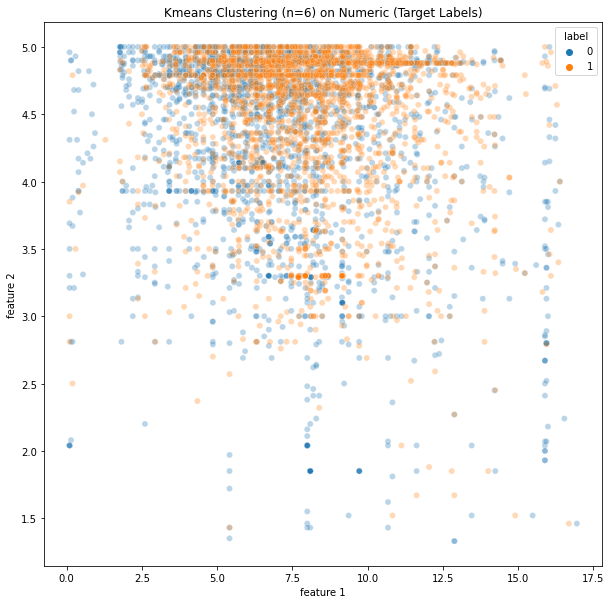

In [ ]:
c_labels = metrics['best_model'].labels_
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Numeric (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=sample_df['d_chall_score'],
                y=sample_df['conc_rating_max'],
                hue=sample_df.label,
                alpha=.3);


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Best Score: 0.5807250572847593


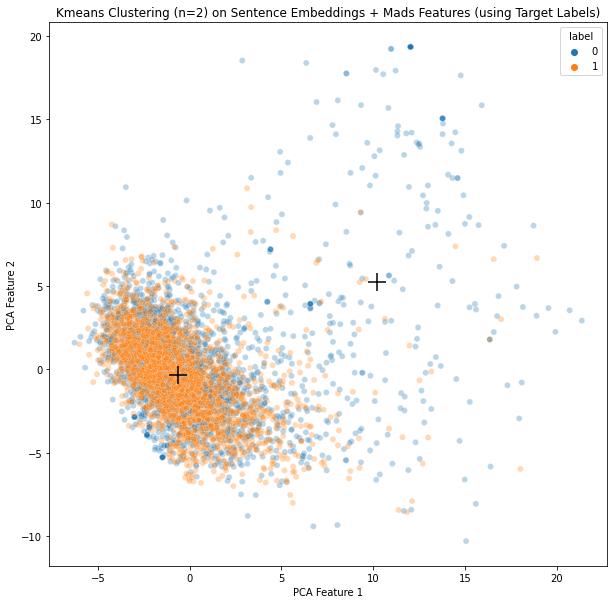

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)
num_df = pd.DataFrame(X_num_std, columns=num_features)


X_emb_mads = pd.concat([pd.DataFrame(X_std), num_df], axis=1)
X_em_std = StandardScaler().fit_transform(X_emb_mads)
X_em_pca = PCA(n_components=5).fit_transform(X_em_std)

results = find_best_kmeans(X_em_pca, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
feat_one = X_em_pca[:,0]
feat_two = X_em_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings + Mads Features (using Target Labels)"
plot_clusters(feat_one,
              feat_two,
              sample_df.label, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


# Using UMAP For Dimensionality-Reduction

In [10]:
import umap

In [11]:
# Code obtained and slightly modified from https://umap-learn.readthedocs.io/en/latest/parameters.html

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    data=X_std
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),c=data[:,0])
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data[:,0])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


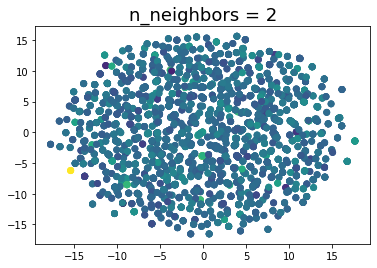

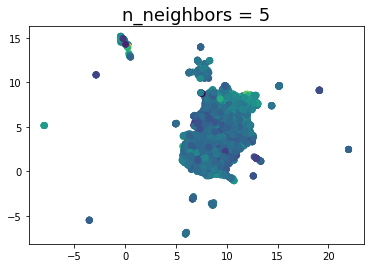

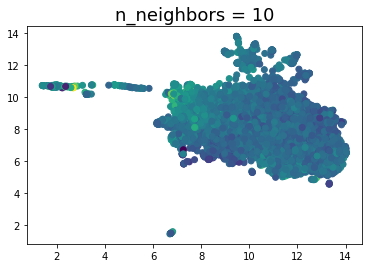

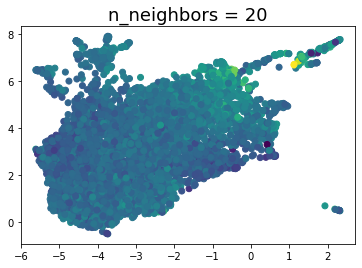

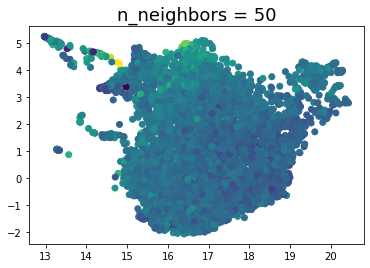

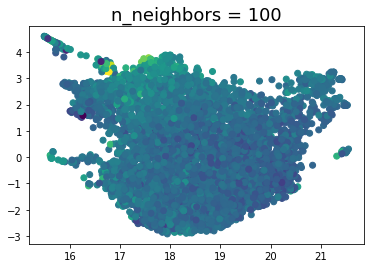

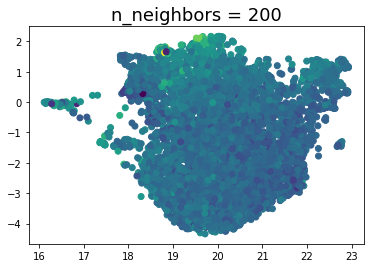

In [ ]:
# reducer = umap.UMAP(n_neighbors=5, n_components=2)
# embs = reducer.fit_transform(X_std)

for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [15]:
# %pip install umap-learn
#%pip install "umap-learn[plot]"

In [14]:
import umap.plot

Text(0.5, 1.0, 'Umap Results with Target Labels')

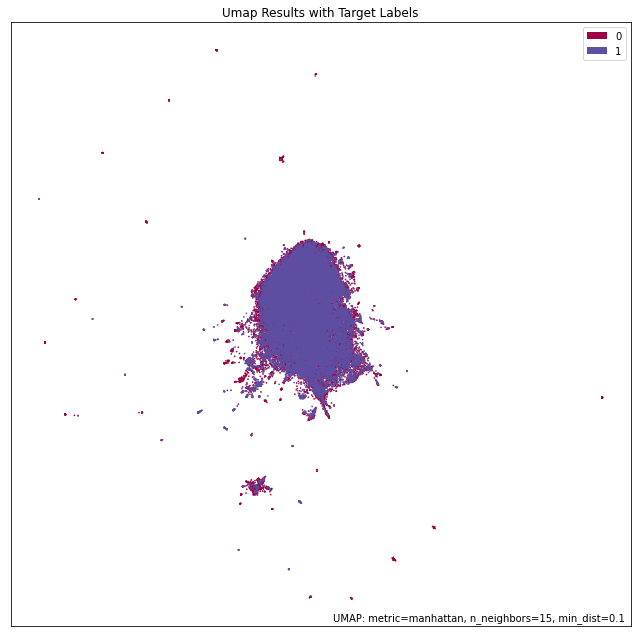

In [16]:
X_std = StandardScaler().fit_transform(X)
mapper = umap.UMAP(metric='manhattan', random_state=99).fit(X_std)
umap.plot.points(mapper,labels=sample_df.label)
plt.title("Umap Results with Target Labels")

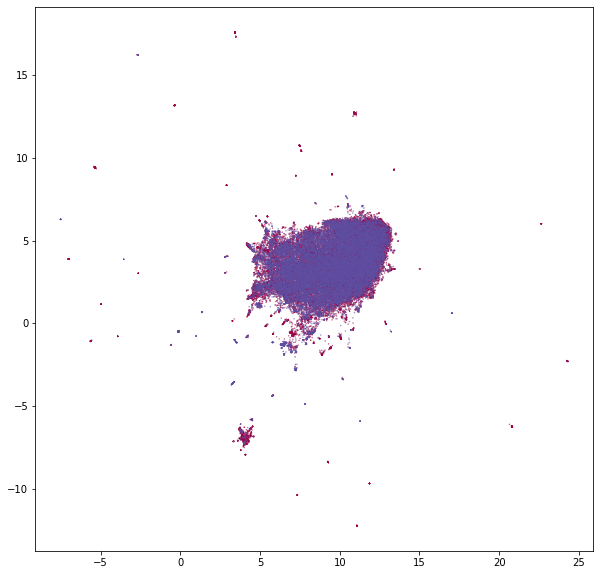

In [ ]:
standard_embedding = umap.UMAP(metric='euclidean',
                               random_state=99).fit_transform(X_std)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding[:, 0], 
            standard_embedding[:, 1],
            c=sample_df.label, s=0.1, cmap='Spectral')


In [19]:
def find_best_clus_metric(lst_metrics):

  metrics = {'metric': [],
            'clusters': [],
            'score': []
            }

  clus_range = [x for x in range(2,10)]
  for m in lst_metrics:
    mapping = umap.UMAP(metric=m,
                                random_state=99).fit_transform(X_std)
    results = find_best_kmeans(mapping,clus_range)
    for idx, score in enumerate(results['score']):
      metrics['metric'].append(m)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return metrics



lst_metrics = ['manhattan', 'euclidean','cosine','correlation']

metrics = find_best_clus_metric(lst_metrics)




In [ ]:
umap_res = pd.DataFrame(metrics)
umap_res.sort_values('score', ascending=False)[:5]

,metric,clusters,score
16,cosine,2,0.485775
24,correlation,2,0.480532
26,correlation,4,0.451779
18,cosine,4,0.444049
2,manhattan,4,0.431296


In [ ]:
# None of the kmeans scores using UMAP are better than what we were able to get through standard PCA
# The table above shows the 5 highest silo scores based on the metric passed to UMAP and the best clusters found
# found by k-means. Of the 4 measures used to reduce dimensions, cosine and correlation measures
# produced the highest scores (top 4 of 5)

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


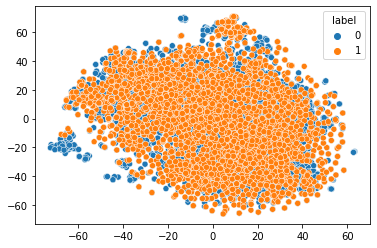

In [ ]:
for lr in [10,100,500,1000]:
  tsne= TSNE(learning_rate = lr,
             random_state=99,
             n_jobs=-1)
  X_tsne = tsne.fit_transform(X_std)
  
  
  
  sns.scatterplot(X_tsne[:,0],X_tsne[:,1], hue=sample_df['label'] )

## Agglomerative Clustering

In [59]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [60]:
X_std.shape

(20000, 96)

In [61]:
# code from https://www.projectpro.io/recipes/do-agglomerative-clustering-in-python

clt = AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=5)
model = clt.fit(X_std)
clusters = model.fit_predict(X_std)
sample_df['agg_cluster'] = clusters

(20000,)

In [62]:
X_pca = PCA(n_components=5, random_state=99).fit_transform(X_std)

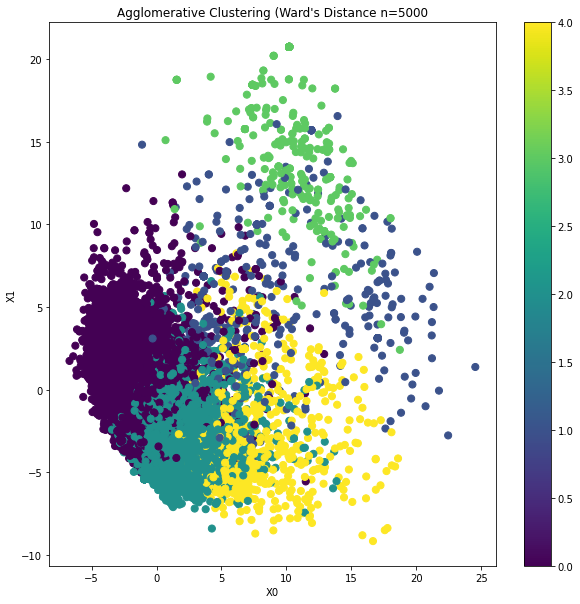

In [63]:
  fig = plt.figure(figsize=(10,10)); 
  ax = fig.add_subplot(111)
  scatter = ax.scatter(X_pca[:,0],X_pca[:,1], c=sample_df.agg_cluster,s=50)
  ax.set_title(f"Agglomerative Clustering (Ward's Distance n={len(sample_df)}")
  ax.set_xlabel("X0"); ax.set_ylabel("X1")
  plt.colorbar(scatter); plt.show()



In [75]:
def find_best_agg_clusters(X,n_clus_lst):
 
  m = {'cluster':[],
       'score':[],
       'affinity':[],
       'best_model':None}

  for idx, n in enumerate(n_clus_lst):
    for measure in ['euclidean','l1','cosine']:    
      clt = AgglomerativeClustering(linkage="ward",
                                    affinity=measure,
                                    n_clusters=n)
      model = clt.fit(X_std)
      clusters = model.fit_predict(X)
      score = silhouette_score(X,clusters,
                      random_state=99)
      m['cluster'].append(n)
      m['affinity'].append(measure)
      if m['best_model'] == None:
        m['best_model'] = model
      elif score > np.max(m['score']):
        m['best_model'] = model    
      m['score'].append(score)
    
  return m

SyntaxError: ignored

In [74]:
results = find_best_agg_clusters(X_std,[x for x in range(2,10)])
results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9],
 'score': [0.54918826,
  0.07279946,
  0.07534115,
  0.053264525,
  0.028804109,
  0.007158834,
  0.008663158,
  0.010102293],
 'best_model': AgglomerativeClustering()}

In [55]:
from pandas import option_context
df_review = sample_df.groupby('agg_cluster').apply(lambda x: x.sample(5, random_state=99))

with option_context('display.max_colwidth', 400):
    display(df_review[['original_text', 'label']])



original_text  \
agg_cluster ix                                                                                                                                                                                       
0           118697                                                     The name Nicole was not retired due to its lack of effects , and it is on the list for the 2010 Atlantic hurricane season .   
            21544                                  On the 14th day of the infection , biopsies of Marshall 's stomach did not reveal any bacteria , so spontaneous eradication may have occurred .   
            386687                                                                                  1986 -LRB- MCMLXXXVI -RRB- was a common year starting on Wednesday of the Gregorian calendar .   
            188842                                                                                                         It was a youth-oriented phenomenon that emphasized the new and modern .   
            364088                                                                                       It is one of the most commonly seen wild animals of northern India and eastern Pakistan .   
1           303963                                                                                                                                                                        Official   
            393486                                                                                                                                                           Discrete-time signals   
            213914                                                                                                                                                          Athens Olympic Stadium   
            299540                                                                                                                                                                        Official   
            387955                                                                                                                                                             Complex life cycles   
2           329540       The president of the Catholic League , William Donohue , said that the president of the Oregon University , Dave Frohnmayer , is partially responsible for the pictures .   
            238863                                                                                             The Trolleybus Museum at Sandtoft is a transport museum that has old trolleybuses .   
            368836                                                                                                                               It formed off the coast of Costa Rica on May 29 .   
            349911                                                                                                                PojorÃ cents ta is a commune found in Suceava County , Romania .   
            330177                                                                                                                                Sommerfeld died in 1951 by an traffic accident .   
3           319279                                                                                                                                                                        Releases   
            410482                                                                                                                                                                      References   
            326144                                                                                                                                                                          Gordon   
            391393                                                                                                                                                                         History   
            221416     

1

In [53]:
from scipy.cluster.hierarchy import ward, dendrogram
plt.figure(figsize=(30,20))
dendrogram()
plt.show()

TypeError: ignored

<Figure size 2160x1440 with 0 Axes>